Make a truthset for each combination of (1) a specific exponential model of AAF distribution, (2) variant type (3) sample and region.

In [218]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import attila_utils
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
from IPython.display import set_matplotlib_formats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import truth_sets_aaf as tsa
import pandas as pd
import multi_prec_recall as multipr

Read in model parameters into `expm` for all combinations and create a truthset for each combination storing the names of output VCFs in `outvcfs`.

In [3]:
expm = pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/exp_model.csv',
                   dtype={'lambda': 'category', 'region': 'category', 'sample': 'category', 'vartype': 'category', 'log10s2g': 'category'})

In [4]:
#outvcfs = tsa.downsample_absolutely_all_vcfs(expm, topdir='/home/attila/projects/bsm/results/2019-03-18-truth-sets', seed=19760415)
#pd.DataFrame({'outvcf': outvcfs}).to_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv', index=False)

Let's write the pathnames for the resulting truthset VCFs to a CSV file!

In [5]:
outvcfs = list(pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv')['outvcf'])

In [217]:
pr = multipr.run_all()

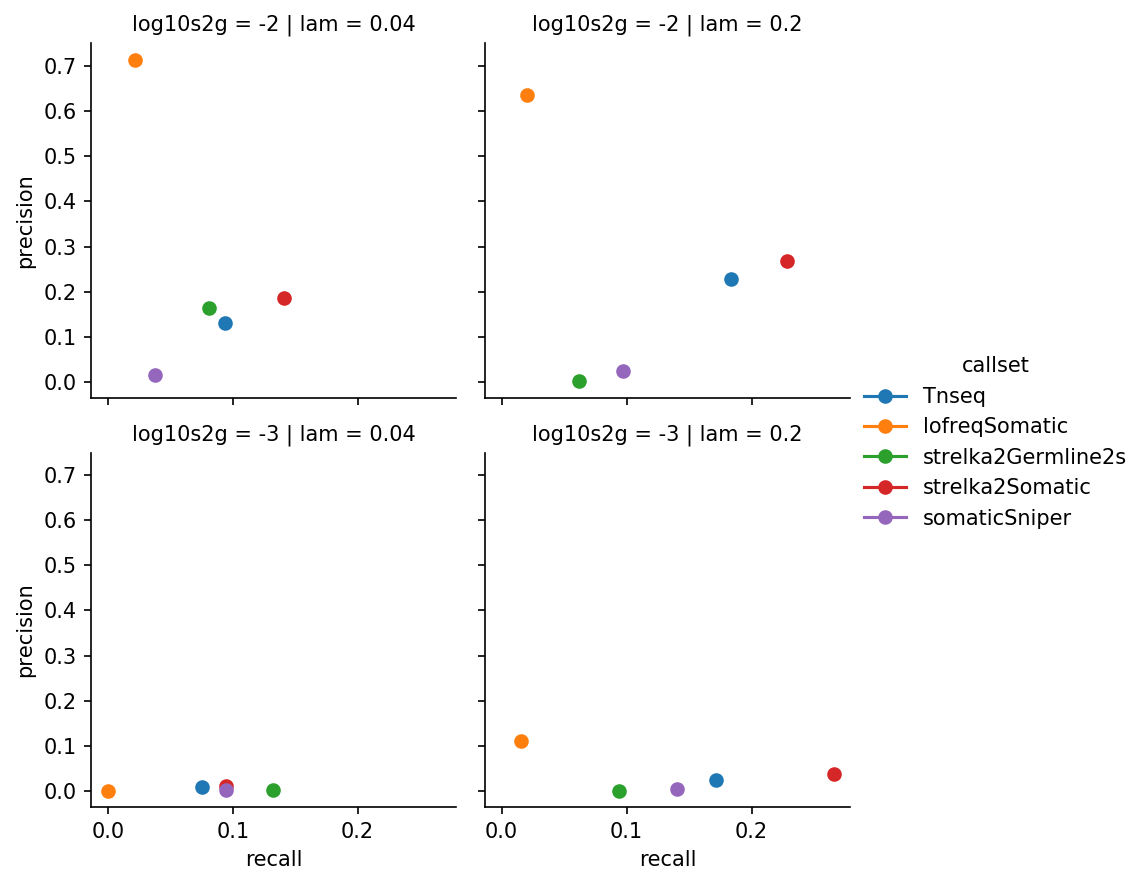

In [219]:
fg = multipr.plotter1(df=pr.loc[pr['region'] == 'chr22', :])